# DSBA 22/23 HSE & University of London

# Practical assignment 1. DL in classification.

## General info
Release data: 26.09.2022

Soft deadline: 10.10.2022 23:59 MSK

Hard deadline: 13.10.2021 23:59 MSK

In this task, you are to build a NN for a binary classification task. We suggest using Google Colab for access to GPU. Competition invite link: https://www.kaggle.com/t/1917e22edb71437ca24d790ab1d57695

## Evaluation and fines

Each section has a defined "value" (in brackets near the section). Maximum grade for the task - 10 points, other points can be assigned to your tests.

**Your notebook with the best solution must be reproducible should be sent to the dropbox!** If the assessor cannot reproduce your results, you may be assigned score = 0, so make all your computations fixed!

**You can only use neural networks / linear / nearest neighbors models for this task - tree-based models are forbidden!**

All the parts must be done independently.

After the hard deadline is passed, the hometask is not accepted. If you send the hometask after the soft deadline, you will be excluded from competition among your mates and the homework will only be scored by the "Beating the baseline" part.

Feel free to ask questions both the teacher and your mates, but __do not copy the code or do it together__. "Similar" solutions are considered a plagiarism and all the involved students (the ones who gave & the ones who did) cannot get more than 0.01 points for the task. If you found a solution in some open source, you __must__ reference it in a special block at the end of your work (to exclude the suspicions in plagiarism).


## Format of handing over

The tasks are sent to the dropbox: https://www.dropbox.com/request/Y6TJouxNbm3r0RgcBL35. Don't forget to attach your name, surname & your group.


## 1. Model training

**Important!** Public Leaderboard contains only 33% of the test data. Your points will be measured wrt to the whole test set, therefore your position on the LB after the end of the competition may change.

* test_accuracy > weak baseline (public LB): 3 points

* test_accuracy > medium baseline (public LB): + 3 points

* test_accuracy > strong baseline (public LB): + 2 points

* You are among 25% most successful students (private LB): + 2 point

* You are among top-3 most successful students (private LB): + 1 point

* You are among top-2 most successful students (private LB): + 1 point

* You are among top-1 most successful students (private LB): + 1 point

In [1]:
# Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [4]:
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [5]:
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

In [6]:
import mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# **Preprocessing data**

In [7]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
target_df = pd.read_csv('train_target.csv')
train_expected_target1 = pd.read_csv('train_expected_target_agent_1.csv')
train_expected_target2 = pd.read_csv('train_expected_target_agent_2.csv')
train_target_agent_1 = pd.read_csv('train_target_agent_1.csv')
train_target_agent_2 = pd.read_csv('train_target_agent_2.csv')

In [8]:
train_target_agent_1 = train_target_agent_1.rename(columns={"0": "expected_target1"})
train_target_agent_2 = train_target_agent_2.rename(columns={"0": "expected_target2"})

In [9]:
train_df = pd.concat([train_df, train_target_agent_1, train_target_agent_2], axis=1)

In [10]:
train_df.head()

,agent_1_feat_Possession%,agent_1_feat_Pass%,agent_1_feat_AerialsWon,agent_1_feat_Rating,agent_1_feat_XGrealiz,agent_1_feat_XGArealiz,agent_1_feat_PPDA,agent_1_feat_OPPDA,agent_1_feat_DC,agent_1_feat_ODC,...,agent_2_feattotal_xg_1,agent_2_feattotal_xg_mean_3,agent_2_feattotal_xg_mean,agent_2_featboth_scored_3,agent_2_featboth_scored_2,agent_2_featboth_scored_1,agent_2_featboth_scored_mean_3,agent_2_featboth_scored_mean,expected_target1,expected_target2
0,58.8,85.1,15.8,6.99,1.143700,0.928715,7.13,14.16,267.0,194.0,...,2.739439,2.739439,NaN,0.473684,0.473684,0.473684,0.473684,NaN,1,2
1,44.8,71.1,23.4,6.84,0.954159,0.975350,9.99,7.66,191.0,287.0,...,2.336756,2.336756,NaN,0.578947,0.578947,0.578947,0.578947,NaN,2,2
2,46.3,70.8,21.7,6.77,0.918434,1.118603,9.56,7.34,179.0,298.0,...,2.120322,2.120322,NaN,0.368421,0.368421,0.368421,0.368421,NaN,0,1
3,50.2,77.5,24.4,6.87,1.037613,0.956836,9.60,9.53,195.0,239.0,...,2.216415,2.216415,NaN,0.210526,0.210526,0.210526,0.210526,NaN,0,1
4,44.9,75.0,17.2,6.77,0.983691,0.948837,12.24,8.76,161.0,283.0,...,2.604025,2.604025,NaN,0.421053,0.421053,0.421053,0.421053,NaN,2,2


In [11]:
test_df.head()

,agent_1_feat_Possession%,agent_1_feat_Pass%,agent_1_feat_AerialsWon,agent_1_feat_Rating,agent_1_feat_XGrealiz,agent_1_feat_XGArealiz,agent_1_feat_PPDA,agent_1_feat_OPPDA,agent_1_feat_DC,agent_1_feat_ODC,...,agent_2_feattotal_xg_3,agent_2_feattotal_xg_2,agent_2_feattotal_xg_1,agent_2_feattotal_xg_mean_3,agent_2_feattotal_xg_mean,agent_2_featboth_scored_3,agent_2_featboth_scored_2,agent_2_featboth_scored_1,agent_2_featboth_scored_mean_3,agent_2_featboth_scored_mean
0,58.6,87.0,15.2,6.83,0.844742,1.165049,9.19,16.50,337.0,179.0,...,2.661870,1.893116,4.241360,2.932115,2.690442,1.0,0.0,1.0,0.666667,0.333333
1,50.7,81.3,14.2,6.65,0.743218,1.152593,10.31,13.63,311.0,208.0,...,3.550724,2.373700,4.197010,3.373811,3.075302,0.0,1.0,1.0,0.666667,0.625000
2,47.3,81.4,17.7,6.73,0.954509,0.956938,14.21,11.82,207.0,270.0,...,2.693652,2.042668,0.966665,1.900995,3.007033,0.0,1.0,1.0,0.666667,0.555556
3,54.5,84.8,14.5,6.85,1.155612,1.049618,10.95,12.46,339.0,186.0,...,3.938100,1.466409,0.922046,2.108852,2.643923,1.0,0.0,0.0,0.333333,0.444444
4,51.3,81.8,16.4,6.81,1.199718,0.856327,11.27,11.52,193.0,293.0,...,3.358338,2.138405,1.872476,2.456406,3.113815,0.0,0.0,0.0,0.000000,0.555556


In [12]:
train_df.shape

(2470, 236)

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2470 entries, 0 to 2469
Columns: 236 entries, agent_1_feat_Possession% to expected_target2
dtypes: float64(212), int64(24)
memory usage: 4.4 MB


In [14]:
target_df.drop('id', axis = 1, inplace = True)

In [15]:
train_df = pd.concat([target_df, train_df], axis = 1)

In [16]:
train_df

,category,agent_1_feat_Possession%,agent_1_feat_Pass%,agent_1_feat_AerialsWon,agent_1_feat_Rating,agent_1_feat_XGrealiz,agent_1_feat_XGArealiz,agent_1_feat_PPDA,agent_1_feat_OPPDA,agent_1_feat_DC,...,agent_2_feattotal_xg_1,agent_2_feattotal_xg_mean_3,agent_2_feattotal_xg_mean,agent_2_featboth_scored_3,agent_2_featboth_scored_2,agent_2_featboth_scored_1,agent_2_featboth_scored_mean_3,agent_2_featboth_scored_mean,expected_target1,expected_target2
0,1,58.8,85.1,15.8,6.99,1.143700,0.928715,7.13,14.16,267.0,...,2.739439,2.739439,NaN,0.473684,0.473684,0.473684,0.473684,NaN,1,2
1,1,44.8,71.1,23.4,6.84,0.954159,0.975350,9.99,7.66,191.0,...,2.336756,2.336756,NaN,0.578947,0.578947,0.578947,0.578947,NaN,2,2
2,0,46.3,70.8,21.7,6.77,0.918434,1.118603,9.56,7.34,179.0,...,2.120322,2.120322,NaN,0.368421,0.368421,0.368421,0.368421,NaN,0,1
3,0,50.2,77.5,24.4,6.87,1.037613,0.956836,9.60,9.53,195.0,...,2.216415,2.216415,NaN,0.210526,0.210526,0.210526,0.210526,NaN,0,1
4,1,44.9,75.0,17.2,6.77,0.983691,0.948837,12.24,8.76,161.0,...,2.604025,2.604025,NaN,0.421053,0.421053,0.421053,0.421053,NaN,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2465,1,41.6,76.0,17.1,6.62,1.046406,1.032989,18.00,8.27,138.0,...,3.684860,4.024907,3.872622,1.000000,0.000000,0.000000,0.333333,0.444444,1,2
2466,1,42.9,76.1,18.3,6.61,1.161802,1.066236,16.14,7.60,201.0,...,1.568175,2.000313,2.572016,0.000000,0.000000,0.000000,0.000000,0.444444,2,3
2467,0,41.0,72.2,19.1,6.51,1.000858,1.026472,15.99,7.99,164.0,...,3.871643,2.496854,2.555157,0.000000,0.000000,1.000000,0.333333,0.500000,0,5
2468,1,51.4,79.3,14.1,6.62,1.037986,1.161401,9.73,10.47,222.0,...,4.904164,2.977092,2.495116,1.000000,0.000000,0.000000,0.333333,0.222222,1,3


## Delete outliers

In [17]:
train_expected_target1 = train_expected_target1.rename(columns={"0": "train_expected_target1"})
train_expected_target2 = train_expected_target2.rename(columns={"0": "train_expected_target2"})
train_df = pd.concat([train_expected_target1, train_df], axis = 1)
train_df = pd.concat([train_expected_target2, train_df], axis = 1)
train_df.head()

,train_expected_target2,train_expected_target1,category,agent_1_feat_Possession%,agent_1_feat_Pass%,agent_1_feat_AerialsWon,agent_1_feat_Rating,agent_1_feat_XGrealiz,agent_1_feat_XGArealiz,agent_1_feat_PPDA,...,agent_2_feattotal_xg_1,agent_2_feattotal_xg_mean_3,agent_2_feattotal_xg_mean,agent_2_featboth_scored_3,agent_2_featboth_scored_2,agent_2_featboth_scored_1,agent_2_featboth_scored_mean_3,agent_2_featboth_scored_mean,expected_target1,expected_target2
0,0.278076,1.166350,1,58.8,85.1,15.8,6.99,1.143700,0.928715,7.13,...,2.739439,2.739439,NaN,0.473684,0.473684,0.473684,0.473684,NaN,1,2
1,0.613273,1.278300,1,44.8,71.1,23.4,6.84,0.954159,0.975350,9.99,...,2.336756,2.336756,NaN,0.578947,0.578947,0.578947,0.578947,NaN,2,2
2,1.117570,1.900670,0,46.3,70.8,21.7,6.77,0.918434,1.118603,9.56,...,2.120322,2.120322,NaN,0.368421,0.368421,0.368421,0.368421,NaN,0,1
3,0.909774,0.423368,0,50.2,77.5,24.4,6.87,1.037613,0.956836,9.60,...,2.216415,2.216415,NaN,0.210526,0.210526,0.210526,0.210526,NaN,0,1
4,0.991901,1.683430,1,44.9,75.0,17.2,6.77,0.983691,0.948837,12.24,...,2.604025,2.604025,NaN,0.421053,0.421053,0.421053,0.421053,NaN,2,2


In [18]:
print('Rows before deleting: ', train_df.shape[0])
train_df = train_df.drop(train_df[(train_df.train_expected_target2 > 1) &
                                  (train_df.train_expected_target1 > 1) &
                                  (train_df.category == 0)].index)
train_df.drop(['train_expected_target1', 'train_expected_target2'], axis = 1, inplace = True)
print('Rows after deleting: ', train_df.shape[0])

Rows before deleting:  2470
Rows after deleting:  2295


## Work with missing variables

In [26]:
print('Rows before deleting: ', train_df.shape[0])
train_df = train_df.dropna()  
print('Rows after deleting: ', train_df.shape[0])

Rows before deleting:  2295
Rows after deleting:  2163


In [24]:
test_df.isna().sum().sort_values(ascending=False)

agent_2_featboth_scored_mean        20
agent_2_feattotal_xg_mean           20
agent_1_feat_total_scored_mean.1    20
agent_1_feat_both_scored_mean.1     20
agent_2_feattotal_scored_mean       20
                                    ..
agent_1_feat_scheme_10               0
agent_1_feat_scheme_9                0
agent_1_feat_scheme_8                0
agent_1_feat_scheme_7                0
agent_1_feat_Possession%             0
Length: 234, dtype: int64

In [25]:
test_df = test_df.apply(lambda x: x.fillna(x.mean()), axis=0) 
test_df.isna().sum().sort_values(ascending=False)

agent_2_featboth_scored_mean        0
agent_2_feat_PPDA                   0
agent_2_feat_Dispossessed           0
agent_2_feat_UnsuccessfulTouches    0
agent_2_feat_DribbledPast           0
                                   ..
agent_1_feat_scheme_17              0
agent_1_feat_scheme_16              0
agent_1_feat_scheme_15              0
agent_1_feat_scheme_14              0
agent_1_feat_Possession%            0
Length: 234, dtype: int64

# Corr

In [27]:
train_df

,category,agent_1_feat_Possession%,agent_1_feat_Pass%,agent_1_feat_AerialsWon,agent_1_feat_Rating,agent_1_feat_XGrealiz,agent_1_feat_XGArealiz,agent_1_feat_PPDA,agent_1_feat_OPPDA,agent_1_feat_DC,...,agent_2_feattotal_xg_1,agent_2_feattotal_xg_mean_3,agent_2_feattotal_xg_mean,agent_2_featboth_scored_3,agent_2_featboth_scored_2,agent_2_featboth_scored_1,agent_2_featboth_scored_mean_3,agent_2_featboth_scored_mean,expected_target1,expected_target2
20,0,44.0,70.3,25.1,6.79,0.711201,0.915529,10.74,9.43,218.0,...,1.608046,2.112304,1.608046,0.578947,0.578947,1.0,0.719298,1.000000,0,0
21,0,57.0,84.6,15.9,7.07,1.094698,0.938272,7.57,13.92,575.0,...,2.479335,2.214160,2.479335,0.526316,0.526316,1.0,0.684211,1.000000,0,1
22,1,48.1,76.9,17.7,6.74,0.994530,1.235052,9.77,8.24,175.0,...,1.712261,2.183093,1.712261,0.526316,0.526316,1.0,0.684211,1.000000,3,3
23,0,46.3,70.8,21.7,6.77,0.918434,1.118603,9.56,7.34,179.0,...,2.675331,2.627794,2.675331,0.421053,0.421053,1.0,0.614035,1.000000,1,0
24,0,50.7,82.1,14.4,6.86,1.124694,0.875939,11.79,10.66,156.0,...,1.331644,2.260683,1.331644,0.368421,0.368421,0.0,0.245614,0.000000,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2465,1,41.6,76.0,17.1,6.62,1.046406,1.032989,18.00,8.27,138.0,...,3.684860,4.024907,3.872622,1.000000,0.000000,0.0,0.333333,0.444444,1,2
2466,1,42.9,76.1,18.3,6.61,1.161802,1.066236,16.14,7.60,201.0,...,1.568175,2.000313,2.572016,0.000000,0.000000,0.0,0.000000,0.444444,2,3
2467,0,41.0,72.2,19.1,6.51,1.000858,1.026472,15.99,7.99,164.0,...,3.871643,2.496854,2.555157,0.000000,0.000000,1.0,0.333333,0.500000,0,5
2468,1,51.4,79.3,14.1,6.62,1.037986,1.161401,9.73,10.47,222.0,...,4.904164,2.977092,2.495116,1.000000,0.000000,0.0,0.333333,0.222222,1,3


In [28]:
corr_matrix1 = train_df.corr()
corr1 = corr_matrix1["expected_target1"].sort_values(ascending=False)
print(corr1)

expected_target1          1.000000
agent_1_feat_ScoredAv     0.385431
agent_1_feat_XgAv         0.360820
agent_1_feat_DC           0.341588
agent_1_feat_pl_median    0.328869
                            ...   
agent_1_feat_PPDA        -0.213783
agent_2_feat_Rating      -0.215384
agent_1_feat_MissedAv    -0.260551
agent_1_feat_XgaAv       -0.267009
agent_1_feat_ODC         -0.290223
Name: expected_target1, Length: 237, dtype: float64


In [29]:
corr_matrix2 = train_df.corr()
corr2 = corr_matrix2["expected_target2"].sort_values(ascending=False)
print(corr2)

expected_target2         1.000000
category                 0.471964
agent_2_feat_ScoredAv    0.335948
agent_2_feat_XgAv        0.324758
agent_2_feat_pl_mean     0.294398
                           ...   
agent_2_feat_MissedAv   -0.225085
agent_1_feat_pl_mean    -0.225340
agent_2_feat_XgaAv      -0.241378
agent_1_feat_Rating     -0.250496
agent_2_feat_ODC        -0.263211
Name: expected_target2, Length: 237, dtype: float64


In [30]:
# corr1_df = pd.DataFrame({'feature': corr1.index, 'correlation':corr1.values})
# corr1_df

In [31]:
corr2_df = pd.DataFrame({'feature' : corr2.index, 'correlation' : corr2.values})
corr2_df

,feature,correlation
0,expected_target2,1.000000
1,category,0.471964
2,agent_2_feat_ScoredAv,0.335948
3,agent_2_feat_XgAv,0.324758
4,agent_2_feat_pl_mean,0.294398
...,...,...
232,agent_2_feat_MissedAv,-0.225085
233,agent_1_feat_pl_mean,-0.225340
234,agent_2_feat_XgaAv,-0.241378
235,agent_1_feat_Rating,-0.250496


In [163]:
# corr1_df = corr1_df.drop(corr1_df[corr1_df.feature == 'category'].index)
# corr1_df = corr1_df.drop(corr1_df[corr1_df.feature == 'expected_target1'].index)
# corr1_df = corr1_df.drop(corr1_df[corr1_df.feature == 'expected_target2'].index)
# corr1_df = corr1_df.loc[(corr1_df['correlation'] > 0.1) | (corr1_df['correlation'] < -0.1)]
# len(corr1_df)

87

In [33]:
corr2_df = corr2_df.drop(corr2_df[corr2_df.feature == 'category'].index)
corr2_df = corr2_df.drop(corr2_df[corr2_df.feature == 'expected_target1'].index)
corr2_df = corr2_df.drop(corr2_df[corr2_df.feature == 'expected_target2'].index)
corr2_df = corr2_df.loc[(corr2_df['correlation'] > 0.15) | (corr2_df['correlation'] < -0.15)]
len(corr2_df)

60

## Split dataset on train and test

In [35]:
X = train_df.drop(['expected_target1', 'category', 'expected_target2'], axis=1)

# X1 = X[list(corr1_df.feature)]
X2 = X[list(corr2_df.feature)]

X1 = X
# X2 = X

Y_category = train_df['category']
Y_expected1 = train_df['expected_target1']
Y_expected2 = train_df['expected_target2']

# test_df1 = test_df[list(corr1_df.feature)]
test_df2 = test_df[list(corr2_df.feature)]

test_df1 = test_df
# test_df2 = test_df

X_train1, X_test1, y_train1, y_test1 = (X1.iloc[0:int(len(X1)*0.8)], 
                                    X1.iloc[int(len(X1)*0.8):len(X1)], 
                                    Y_expected1.iloc[0:int(len(Y_expected1)*0.8)], 
                                    Y_expected1.iloc[int(len(Y_expected1)*0.8):len(Y_expected1)],)

X_train2, X_test2, y_train2, y_test2 = (X2.iloc[0:int(len(X2)*0.8)], 
                                    X2.iloc[int(len(X2)*0.8):len(X2)], 
                                    Y_expected2.iloc[0:int(len(Y_expected2)*0.8)], 
                                    Y_expected2.iloc[int(len(Y_expected2)*0.8):len(Y_expected2)],)


In [36]:
X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape

((1730, 234), (433, 234), (1730,), (433,))

In [37]:
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((1730, 60), (433, 60), (1730,), (433,))

# **Model**

In [38]:
def create_model(batch_size, epochs, learning_rate, num_classes, input_shape):
    model = Sequential()
    model.add(Dense(128, activation="relu", input_shape=(input_shape, ))) # Hidden Layer 1
    model.add(BatchNormalization())
    
    model.add(Dense(128, activation="relu")) # Hidden Layer 2
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(64, activation="relu")) # Hidden Layer 3
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(64, activation="relu")) # Hidden Layer 4
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(32, activation="relu")) # Hidden Layer 5
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
        
    model.add(Dense(num_classes, activation="softmax")) # Outout Layer
    
    sgd = SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(optimizer=sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return model

In [39]:
def make_equal_dummies(y_train, y_test):
    dif = len(y_train.columns) - len(y_test.columns)
    if dif == 0:
        pass
    elif dif > 0:
        while dif != 0:
            y_test[int(y_test.columns[-1])+1] = 0
            dif -= 1
    else:
        while dif != 0:
            y_train[int(y_train.columns[-1])+1] = 0
            dif += 1
            
    print(y_train.shape, y_test.shape)
    return y_train, y_test

In [40]:
def make_graphs(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.plot(epochs, acc, 'y', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [41]:
def calc_train_acc(model, expected_target, Y_expected, X_test):
    tmp_real_value = train_df[expected_target][int(len(Y_expected)*0.8):len(Y_expected)]
    y_pred = model.predict(X_test)
    tmp_pred_value = []
    for i in y_pred:
        if i.argmax() != 0:
            tmp_pred_value.append(1)
        else:
            tmp_pred_value.append(0)
    
#     print(len(tmp_real_value), len(tmp_pred_value))
    num_matching = 0
    if len(tmp_real_value) == len(tmp_pred_value):
        for i, j in zip(tmp_real_value, tmp_pred_value):
            if i != 0:
                i = 1
            if i == j:
                num_matching += 1
        print("ACC: ", np.round((num_matching / len(tmp_real_value)), 3))
    else:
        print('Not equal siae of predictions')
        
    return tmp_pred_value


In [42]:
def scale_data(X_train, X_test, test_df):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    test_df = scaler.transform(test_df)
    
    return X_train, X_test, test_df

In [43]:
def KNN_model(X_train, y_train, X_test, y_test):
    error_rates = []

    for i in np.arange(1, 100):
        new_model = KNeighborsClassifier(n_neighbors = i)
        new_model.fit(X_train, y_train)
        model = KNeighborsClassifier(n_neighbors = 5)
        model.fit(X_train, y_train)
        new_predictions = new_model.predict(X_test)
        error_rates.append(np.mean(new_predictions != y_test))

    plt.plot(error_rates);
    
    return error_rates

In [44]:
def feature_selection(X_train, y_train, X_test, y_test):
    feature_selection_model = KNeighborsClassifier(n_neighbors = np.argmin(KNN_model(X_train, y_train, X_test, y_test)))
    
    sfs = SFS(feature_selection_model,
          k_features=X_train.shape[1],
          forward=True, 
          floating=False, 
          scoring='accuracy', 
          verbose=1,
          cv=StratifiedKFold(n_splits=5),
          n_jobs=-1
          )

    sfs = sfs.fit(X_train, y_train)
    
    sfs_data = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

    sfs_data['avg_score'] = pd.to_numeric(sfs_data['avg_score'])
    fearues_names = (sfs_data.loc[sfs_data['avg_score'].idxmax(), 'feature_names'])
    
    return fearues_names

In [45]:
def grid_search(X_train, y_train, expected_target):
    batch_size = [16, 32, 64, 128]
    epochs = [50, 75, 125]
    learning_rate = [0.001, 0.0001]
    num_classes = [train_df[expected_target].nunique()]
    input_shape = [X_train.shape[1]]
    param_opt = dict(batch_size=batch_size,
                     epochs=epochs,
                     learning_rate=learning_rate,
                     num_classes=num_classes,
                     input_shape=input_shape)


    model_GridSearch = KerasClassifier(build_fn=create_model, 
                                       verbose=0)
    grid = GridSearchCV(estimator=model_GridSearch, 
                        param_grid=param_opt, 
                        n_jobs=-1, 
                        cv=5, 
                        verbose = 0)
    grid_result = grid.fit(X_train, y_train)
    
    print('Best parameters are: ')
    print('batch_size: ' + str(grid_result.best_params_['batch_size']))
    print('epochs: ' + str(grid_result.best_params_['epochs']))
    print('learning_rate: ' + str(grid_result.best_params_['learning_rate']))
    
    return grid_result

# Model for Agent1

## Feature selection 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 234 out of 234 | elapsed:    4.2s finished
Features: 1/234[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 222 out of 233 | elapsed:    3.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 233 out of 233 | elapsed:    3.3s finished
Features: 2/234[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 221 out of 232 | elapsed:    3.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 232 out of 232 | elapsed:    3.5s finished
Features: 3/234[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 

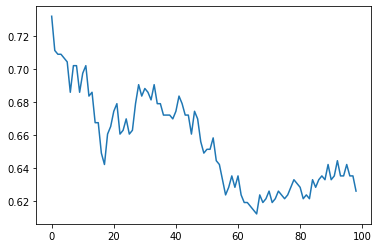

In [47]:
fearues_names1 = feature_selection(X_train1, y_train1, X_test1, y_test1)

## Main model

In [48]:
new_X_train1 = X_train1[list(fearues_names1)]
new_X_train1

,agent_1_feat_AerialsWon,agent_1_feat_Rating,agent_1_feat_XGrealiz,agent_1_feat_XGArealiz,agent_1_feat_PPDA,agent_1_feat_OPPDA,agent_1_feat_Coach,agent_1_feat_ScoredAv,agent_1_feat_MissedAv,agent_1_feat_XgAv,...,agent_2_feattotal_xg_3,agent_2_feattotal_xg_2,agent_2_feattotal_xg_1,agent_2_feattotal_xg_mean_3,agent_2_feattotal_xg_mean,agent_2_featboth_scored_3,agent_2_featboth_scored_2,agent_2_featboth_scored_1,agent_2_featboth_scored_mean_3,agent_2_featboth_scored_mean
20,25.1,6.79,0.711201,0.915529,10.74,9.43,135.1917,0.736842,1.394737,1.036053,...,2.364433,2.364433,1.608046,2.112304,1.608046,0.578947,0.578947,1.0,0.719298,1.000000
21,15.9,7.07,1.094698,0.938272,7.57,13.92,154.0908,2.184211,1.000000,1.995263,...,2.081572,2.081572,2.479335,2.214160,2.479335,0.526316,0.526316,1.0,0.684211,1.000000
22,17.7,6.74,0.994530,1.235052,9.77,8.24,133.6599,1.052632,1.657895,1.058421,...,2.418509,2.418509,1.712261,2.183093,1.712261,0.526316,0.526316,1.0,0.684211,1.000000
23,21.7,6.77,0.918434,1.118603,9.56,7.34,121.3641,1.105263,1.921053,1.203421,...,2.604025,2.604025,2.675331,2.627794,2.675331,0.421053,0.421053,1.0,0.614035,1.000000
24,14.4,6.86,1.124694,0.875939,11.79,10.66,122.7303,1.210526,1.289474,1.076316,...,2.725202,2.725202,1.331644,2.260683,1.331644,0.368421,0.368421,0.0,0.245614,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,14.1,6.52,0.698362,1.047340,12.59,9.65,136.2900,0.684211,1.973684,0.979737,...,3.212219,1.717480,4.247550,3.059083,3.059083,1.000000,0.000000,1.0,0.666667,0.666667
1974,21.9,6.59,0.741351,1.075088,12.20,9.64,135.4500,0.947368,1.684211,1.277895,...,2.939630,3.352280,1.768421,2.686777,2.686777,1.000000,1.000000,0.0,0.666667,0.666667
1975,22.9,6.72,0.998573,0.907494,13.22,9.50,146.5800,1.289474,1.631579,1.291316,...,2.089692,2.912603,1.626763,2.209686,2.209686,0.000000,1.000000,0.0,0.333333,0.333333
1977,21.7,6.71,0.902655,1.060258,8.26,9.97,138.1800,1.342105,1.578947,1.486842,...,3.469760,2.973320,4.561580,3.668220,3.668220,0.000000,1.000000,1.0,0.666667,0.666667


In [49]:
new_X_test1 = X_test1[list(fearues_names1)]
new_X_test1

,agent_1_feat_AerialsWon,agent_1_feat_Rating,agent_1_feat_XGrealiz,agent_1_feat_XGArealiz,agent_1_feat_PPDA,agent_1_feat_OPPDA,agent_1_feat_Coach,agent_1_feat_ScoredAv,agent_1_feat_MissedAv,agent_1_feat_XgAv,...,agent_2_feattotal_xg_3,agent_2_feattotal_xg_2,agent_2_feattotal_xg_1,agent_2_feattotal_xg_mean_3,agent_2_feattotal_xg_mean,agent_2_featboth_scored_3,agent_2_featboth_scored_2,agent_2_featboth_scored_1,agent_2_featboth_scored_mean_3,agent_2_featboth_scored_mean
1979,19.8,6.65,1.041381,0.865284,19.00,7.55,129.36,1.000000,1.526316,0.960263,...,1.450676,2.673176,1.792020,1.971957,1.971957,1.0,1.0,0.0,0.666667,0.666667
1980,23.1,6.68,0.819214,1.137980,10.17,10.38,129.57,1.157895,1.473684,1.413421,...,5.751160,1.940299,3.615030,3.768830,3.679915,1.0,0.0,1.0,0.666667,0.750000
1981,19.0,6.62,0.909293,0.935754,12.34,7.89,130.41,1.078947,1.763158,1.186579,...,3.169215,2.313990,4.880693,3.454633,2.972359,0.0,0.0,0.0,0.000000,0.000000
1982,21.1,6.60,0.895456,1.027018,13.38,9.15,136.71,1.052632,1.710526,1.175526,...,3.373970,3.194548,2.517099,3.028539,3.040646,0.0,0.0,0.0,0.000000,0.250000
1983,18.7,6.86,0.905155,1.314188,9.01,14.66,135.03,1.815789,1.421053,2.006053,...,1.773550,3.223883,1.878514,2.291982,2.473024,0.0,1.0,0.0,0.333333,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2465,17.1,6.62,1.046406,1.032989,18.00,8.27,130.40,1.210526,1.631579,1.156842,...,6.412100,1.977760,3.684860,4.024907,3.872622,1.0,0.0,0.0,0.333333,0.444444
2466,18.3,6.61,1.161802,1.066236,16.14,7.60,139.00,1.078947,1.736842,0.928684,...,2.689307,1.743456,1.568175,2.000313,2.572016,0.0,0.0,0.0,0.000000,0.444444
2467,19.1,6.51,1.000858,1.026472,15.99,7.99,135.00,0.921053,2.000000,0.920263,...,1.875957,1.742962,3.871643,2.496854,2.555157,0.0,0.0,1.0,0.333333,0.500000
2468,14.1,6.62,1.037986,1.161401,9.73,10.47,151.00,1.236842,1.789474,1.191579,...,1.913804,2.113308,4.904164,2.977092,2.495116,1.0,0.0,0.0,0.333333,0.222222


In [50]:
new_test_df1 = test_df1[list(fearues_names1)]
new_test_df1

,agent_1_feat_AerialsWon,agent_1_feat_Rating,agent_1_feat_XGrealiz,agent_1_feat_XGArealiz,agent_1_feat_PPDA,agent_1_feat_OPPDA,agent_1_feat_Coach,agent_1_feat_ScoredAv,agent_1_feat_MissedAv,agent_1_feat_XgAv,...,agent_2_feattotal_xg_3,agent_2_feattotal_xg_2,agent_2_feattotal_xg_1,agent_2_feattotal_xg_mean_3,agent_2_feattotal_xg_mean,agent_2_featboth_scored_3,agent_2_featboth_scored_2,agent_2_featboth_scored_1,agent_2_featboth_scored_mean_3,agent_2_featboth_scored_mean
0,15.2,6.83,0.844742,1.165049,9.19,16.50,144.0,1.526316,0.947368,1.806842,...,2.661870,1.893116,4.241360,2.932115,2.690442,1.0,0.0,1.0,0.666667,0.333333
1,14.2,6.65,0.743218,1.152593,10.31,13.63,146.2,1.052632,1.210526,1.416316,...,3.550724,2.373700,4.197010,3.373811,3.075302,0.0,1.0,1.0,0.666667,0.625000
2,17.7,6.73,0.954509,0.956938,14.21,11.82,169.0,1.236842,1.263158,1.295789,...,2.693652,2.042668,0.966665,1.900995,3.007033,0.0,1.0,1.0,0.666667,0.555556
3,14.5,6.85,1.155612,1.049618,10.95,12.46,138.2,1.921053,1.157895,1.662368,...,3.938100,1.466409,0.922046,2.108852,2.643923,1.0,0.0,0.0,0.333333,0.444444
4,16.4,6.81,1.199718,0.856327,11.27,11.52,170.0,1.789474,1.184211,1.491579,...,3.358338,2.138405,1.872476,2.456406,3.113815,0.0,0.0,0.0,0.000000,0.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,16.1,6.72,0.814332,1.292407,13.35,8.32,134.8,1.000000,1.600000,1.228000,...,2.369897,4.584170,3.757075,3.570381,3.240205,0.0,1.0,0.0,0.333333,0.666667
566,14.0,6.69,1.186944,0.769231,14.87,14.67,150.6,1.000000,1.500000,0.842500,...,3.465800,2.800194,4.670804,3.645599,3.315186,0.0,1.0,0.0,0.333333,0.611111
567,15.1,7.05,0.877193,0.257069,9.05,22.23,190.0,2.400000,0.200000,2.736000,...,1.745647,1.865882,3.505180,2.372236,2.343328,0.0,0.0,1.0,0.333333,0.277778
568,12.7,7.11,0.846805,0.401606,7.86,26.84,189.4,2.200000,0.200000,2.598000,...,3.534070,0.828837,3.122840,2.495249,2.364201,1.0,0.0,1.0,0.666667,0.444444


### Scale data 

In [51]:
new_X_train1, new_X_test1, new_test_df1 = scale_data(new_X_train1, new_X_test1, new_test_df1)

In [52]:
y_train1 = pd.get_dummies(y_train1)
y_test1 = pd.get_dummies(y_test1)
y_train1, y_test1 = make_equal_dummies(y_train1, y_test1)

(1730, 9) (433, 9)


In [53]:
# grid_results1 = grid_search(new_X_train1, y_train1, 'expected_target1')
# batch_size1 = grid_results1.best_params_['batch_size']
# epochs1 = grid_results1.best_params_['epochs']
# learning_rate1 = grid_results1.best_params_['learning_rate']

In [54]:
batch_size1 = 32
epochs1 = 100
learning_rate1 = 0.001

In [55]:
num_classes = train_df['expected_target1'].nunique()
model1 = create_model(batch_size1, epochs1, learning_rate1, num_classes, new_X_train1.shape[1])
history1 = model1.fit(new_X_train1, y_train1, 
                      batch_size = batch_size1, 
                      epochs = epochs1,
                      validation_data = (new_X_test1, y_test1),
)

Epoch 1/100
55/55 [==============================] - 1s 6ms/step - loss: 2.7821 - accuracy: 0.1225 - val_loss: 2.1124 - val_accuracy: 0.1801
Epoch 2/100
55/55 [==============================] - 0s 2ms/step - loss: 2.4715 - accuracy: 0.1642 - val_loss: 1.9955 - val_accuracy: 0.2356
Epoch 3/100
55/55 [==============================] - 0s 2ms/step - loss: 2.2353 - accuracy: 0.2127 - val_loss: 1.9565 - val_accuracy: 0.2425
Epoch 4/100
55/55 [==============================] - 0s 2ms/step - loss: 2.1135 - accuracy: 0.2370 - val_loss: 1.9652 - val_accuracy: 0.2725
Epoch 5/100
55/55 [==============================] - 0s 2ms/step - loss: 1.9694 - accuracy: 0.2717 - val_loss: 1.8392 - val_accuracy: 0.2910
Epoch 6/100
55/55 [==============================] - 0s 2ms/step - loss: 1.9134 - accuracy: 0.2884 - val_loss: 1.7831 - val_accuracy: 0.2933
Epoch 7/100
55/55 [==============================] - 0s 2ms/step - loss: 1.8532 - accuracy: 0.2954 - val_loss: 1.7354 - val_accuracy: 0.2933
Epoch 8/100
5

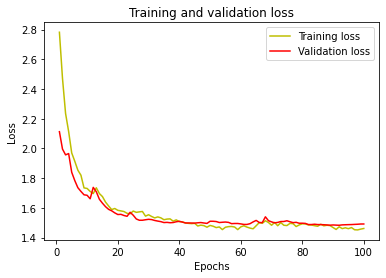

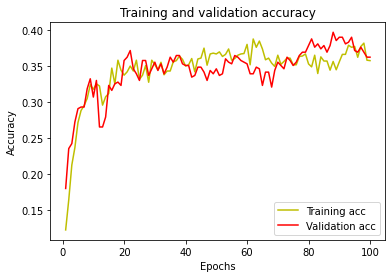

In [56]:
make_graphs(history1)

In [57]:
tmp_pred_value1 = calc_train_acc(model1, 'expected_target1', Y_expected1, new_X_test1)

ACC:  0.764


# Model for agent2

## Feature selection 

In [115]:
# fearues_names2 = feature_selection(X_train2, y_train2, X_test2, y_test2)

## Main model

In [188]:
new_X_train2 = X_train2[list(fearues_names2)]
new_X_train2

,agent_2_feat_ScoredAv,agent_2_feat_XgAv,agent_2_feat_pl_mean,agent_1_feat_MissedAv,agent_2_feat_Rating,agent_1_feat_XgaAv,agent_2_feat_xg_mean_3,agent_2_feat_scored_mean_3,agent_2_feat_form_mean_3,agent_2_feat_scored_3,...,agent_1_feat_scored_1.1,agent_1_feat_xg_2,agent_2_feat_xga_mean_3,agent_1_feat_form_mean_3,agent_1_feat_scored_mean_3.1,agent_1_feat_xg_mean_3,agent_1_feat_XgAv,agent_2_feat_MissedAv,agent_2_feat_XgaAv,agent_1_feat_Rating
20,1.631579,1.426579,80.272727,1.394737,6.99,1.523421,1.178134,1.210526,-0.228070,1.631579,...,1.0,0.371141,0.664349,-0.771930,0.824561,0.750198,1.036053,0.973684,1.048421,6.79
21,1.263158,1.217368,76.090909,1.000000,6.87,1.065789,1.083304,0.754386,-0.324561,1.263158,...,3.0,1.480530,1.005866,0.815789,2.543860,1.596474,1.995263,1.184211,1.237632,7.07
22,1.236842,1.177895,74.727273,1.657895,6.83,1.342368,0.651080,1.078947,-0.692982,1.236842,...,0.0,0.965583,1.363546,-0.412281,0.912281,0.907779,1.058421,1.342105,1.196842,6.74
23,0.815789,0.985526,75.090909,1.921053,6.75,1.717368,0.881272,1.271930,-0.061404,0.815789,...,0.0,1.900670,1.326438,-0.807018,0.807018,1.393386,1.203421,1.394737,1.354211,6.77
24,1.000000,1.016579,73.818182,1.289474,6.77,1.472105,1.121913,1.000000,-0.043860,1.000000,...,1.0,0.278076,1.024063,0.684211,1.280702,0.756213,1.076316,1.342105,1.414474,6.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,1.078947,1.186579,75.727273,1.973684,6.62,1.884474,1.344915,1.333333,-0.333333,0.000000,...,3.0,0.801428,1.578853,-0.333333,2.666667,1.084952,0.979737,1.763158,1.884211,6.52
1974,1.026316,1.205526,72.818182,1.684211,6.72,1.566579,1.186190,0.666667,-0.333333,0.000000,...,2.0,0.344718,1.602597,-0.666667,1.000000,1.414319,1.277895,1.026316,1.369474,6.59
1975,0.815789,0.906579,76.272727,1.631579,6.68,1.797895,1.122357,1.000000,0.000000,0.000000,...,2.0,0.513760,1.172430,0.333333,1.333333,0.781500,1.291316,1.315789,1.510263,6.72
1977,1.815789,2.006053,80.000000,1.578947,6.86,1.489211,2.855210,2.666667,0.333333,5.000000,...,1.0,2.180210,1.046628,-0.333333,1.000000,1.639787,1.486842,1.421053,1.081316,6.71


In [189]:
new_X_test2 = X_test2[list(fearues_names2)]
new_X_test2

,agent_2_feat_ScoredAv,agent_2_feat_XgAv,agent_2_feat_pl_mean,agent_1_feat_MissedAv,agent_2_feat_Rating,agent_1_feat_XgaAv,agent_2_feat_xg_mean_3,agent_2_feat_scored_mean_3,agent_2_feat_form_mean_3,agent_2_feat_scored_3,...,agent_1_feat_scored_1.1,agent_1_feat_xg_2,agent_2_feat_xga_mean_3,agent_1_feat_form_mean_3,agent_1_feat_scored_mean_3.1,agent_1_feat_xg_mean_3,agent_1_feat_XgAv,agent_2_feat_MissedAv,agent_2_feat_XgaAv,agent_1_feat_Rating
1979,1.736842,1.741842,78.727273,1.526316,6.83,1.763947,1.170650,0.666667,0.000000,1.0,...,0.0,1.098070,0.892297,-0.666667,0.333333,0.481092,0.960263,0.947368,1.001579,6.65
1980,1.289474,1.291316,78.818182,1.473684,6.72,1.295000,1.014997,1.666667,0.000000,2.0,...,1.0,2.358540,1.888677,-1.000000,1.333333,1.642060,1.413421,1.631579,1.797895,6.68
1981,1.026316,1.247895,75.000000,1.763158,6.63,1.884211,1.477451,1.000000,0.000000,0.0,...,2.0,0.914266,1.947001,0.000000,1.333333,2.102665,1.186579,1.421053,1.590000,6.62
1982,0.684211,0.979737,72.818182,1.710526,6.52,1.665526,1.120646,0.333333,-1.000000,0.0,...,2.0,2.319570,2.625453,0.000000,2.000000,1.433756,1.175526,1.973684,1.884474,6.60
1983,1.000000,0.960263,76.727273,1.421053,6.65,1.081316,0.600833,0.333333,0.000000,0.0,...,2.0,4.264430,1.336501,0.333333,1.666667,2.549883,2.006053,1.526316,1.763947,6.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2465,1.631579,1.559474,74.727273,1.631579,6.77,1.579474,0.981234,1.666667,-0.333333,5.0,...,1.0,0.168796,1.369450,-1.000000,0.666667,0.538870,1.156842,1.421053,1.658421,6.62
2466,1.631579,1.587895,77.909091,1.736842,6.77,1.628947,1.702073,1.333333,1.000000,1.0,...,2.0,0.709634,0.410268,0.000000,1.000000,0.453369,0.928684,1.236842,1.312105,6.61
2467,2.184211,2.045263,83.545455,2.000000,7.01,1.948421,2.404496,2.333333,1.000000,1.0,...,0.0,2.463320,0.276812,-0.333333,0.000000,1.265762,0.920263,0.842105,0.805526,6.51
2468,1.447368,1.375000,80.090909,1.789474,6.69,1.540789,2.236761,2.333333,0.666667,4.0,...,1.0,0.500436,0.582768,0.000000,0.333333,0.516526,1.191579,1.026316,1.137632,6.62


In [190]:
new_test_df2 = test_df2[list(fearues_names2)]
new_test_df2

,agent_2_feat_ScoredAv,agent_2_feat_XgAv,agent_2_feat_pl_mean,agent_1_feat_MissedAv,agent_2_feat_Rating,agent_1_feat_XgaAv,agent_2_feat_xg_mean_3,agent_2_feat_scored_mean_3,agent_2_feat_form_mean_3,agent_2_feat_scored_3,...,agent_1_feat_scored_1.1,agent_1_feat_xg_2,agent_2_feat_xga_mean_3,agent_1_feat_form_mean_3,agent_1_feat_scored_mean_3.1,agent_1_feat_xg_mean_3,agent_1_feat_XgAv,agent_2_feat_MissedAv,agent_2_feat_XgaAv,agent_1_feat_Rating
0,0.947368,1.016316,76.909091,0.947368,6.67,0.813158,1.538212,2.000000,-0.666667,3.0,...,1.0,1.379390,1.736522,-0.333333,1.666667,0.895377,1.806842,1.368421,1.373421,6.83
1,0.710526,1.080526,75.181818,1.210526,6.63,1.050263,0.756073,0.666667,-0.666667,1.0,...,3.0,0.177084,2.069040,0.000000,1.333333,1.248041,1.416316,1.394737,1.516842,6.65
2,1.789474,1.547368,77.727273,1.263158,6.80,1.320000,1.322390,2.000000,1.000000,2.0,...,0.0,0.371045,0.419486,0.333333,1.000000,0.421098,1.295789,1.315789,1.238684,6.73
3,0.526316,0.872632,74.909091,1.157895,6.46,1.103158,1.104814,0.666667,-0.333333,0.0,...,2.0,1.189290,0.976729,0.666667,3.000000,1.371087,1.662368,1.657895,1.739737,6.85
4,1.789474,1.900263,86.181818,1.184211,6.82,1.382895,1.407720,0.000000,-0.666667,0.0,...,1.0,3.143720,0.923439,0.666667,1.333333,2.318723,1.491579,1.105263,1.244737,6.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,2.750000,1.905000,81.090909,1.600000,6.71,1.238000,1.130094,1.333333,0.000000,1.0,...,1.0,1.390090,1.992155,0.000000,1.333333,1.827937,1.228000,0.750000,0.892500,6.72
566,0.800000,1.162000,76.181818,1.500000,6.63,1.950000,0.586779,0.666667,-1.000000,1.0,...,3.0,2.272970,1.876742,0.666667,1.333333,1.628449,0.842500,1.200000,1.558000,6.69
567,0.400000,1.644000,78.727273,0.200000,6.69,0.778000,1.031708,1.333333,-0.333333,2.0,...,1.0,1.754170,2.248713,0.666667,2.333333,1.331350,2.736000,1.000000,1.170000,7.05
568,1.600000,0.940000,75.363636,0.200000,6.68,0.498000,1.081035,1.000000,-0.333333,1.0,...,5.0,3.393040,1.591810,0.666667,4.333333,3.198800,2.598000,1.400000,1.018000,7.11


### Scale data 

In [191]:
new_X_train2, new_X_test2, new_test_df2 = scale_data(new_X_train2, new_X_test2, new_test_df2)

In [192]:
y_train2 = pd.get_dummies(y_train2)
y_test2 = pd.get_dummies(y_test2)
y_train2, y_test2 = make_equal_dummies(y_train2, y_test2)

(1730, 9) (433, 9)


In [193]:
# grid_results2 = grid_search(new_X_train2, y_train2, 'expected_target2')
batch_size2 = grid_results2.best_params_['batch_size']
epochs2 = grid_results2.best_params_['epochs']
learning_rate2 = grid_results2.best_params_['learning_rate']

In [194]:
# batch_size2 = 32
# epochs2 = 100
# learning_rate2 = 0.0001

In [195]:
num_classes = train_df['expected_target2'].nunique()
model2 = create_model(batch_size2, epochs2, learning_rate2, num_classes, new_X_train2.shape[1])
history2 = model2.fit(new_X_train2, y_train2, 
                      batch_size = batch_size2, 
                      epochs = epochs2,
                      validation_data = (new_X_test2, y_test2),
)

Epoch 1/75
14/14 [==============================] - 2s 23ms/step - loss: 2.9266 - accuracy: 0.1116 - val_loss: 2.1918 - val_accuracy: 0.1524
Epoch 2/75
14/14 [==============================] - 0s 7ms/step - loss: 2.7972 - accuracy: 0.1347 - val_loss: 2.1496 - val_accuracy: 0.2702
Epoch 3/75
14/14 [==============================] - 0s 7ms/step - loss: 2.6324 - accuracy: 0.1474 - val_loss: 2.1099 - val_accuracy: 0.3118
Epoch 4/75
14/14 [==============================] - 0s 7ms/step - loss: 2.5117 - accuracy: 0.1642 - val_loss: 2.0722 - val_accuracy: 0.3187
Epoch 5/75
14/14 [==============================] - 0s 7ms/step - loss: 2.4728 - accuracy: 0.1855 - val_loss: 2.0368 - val_accuracy: 0.3441
Epoch 6/75
14/14 [==============================] - 0s 7ms/step - loss: 2.3881 - accuracy: 0.1908 - val_loss: 2.0027 - val_accuracy: 0.3510
Epoch 7/75
14/14 [==============================] - 0s 7ms/step - loss: 2.2280 - accuracy: 0.2439 - val_loss: 1.9728 - val_accuracy: 0.3326
Epoch 8/75
14/14 [=

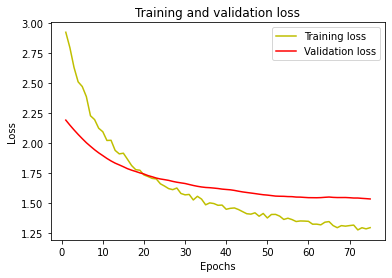

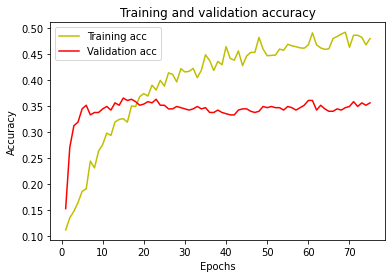

In [196]:
make_graphs(history2)

In [197]:
tmp_pred_value2 = calc_train_acc(model2, 'expected_target2', Y_expected2, new_X_test2)

14/14 [==============================] - 0s 2ms/step
ACC:  0.672


# Test acc

In [123]:
test_pred = np.logical_and(tmp_pred_value1, tmp_pred_value2)
test_pred = [0 if x==False else x for x in test_pred]
test_pred = [1 if x==True else x for x in test_pred]

In [124]:
test_real_value = train_df['category'][int(len(Y_expected1)*0.8):len(Y_expected1)]
test_real_value

1979    0
1980    0
1981    1
1982    0
1983    0
       ..
2465    1
2466    1
2467    0
2468    1
2469    1
Name: category, Length: 433, dtype: int64

In [125]:
acc = 0
for elem1, elem2 in zip(test_pred, test_real_value):
    if elem1 == elem2:
        acc += 1
print("ACC: ", np.round((acc / len(test_real_value)), 3))

ACC:  0.524


# Make a submission

In [126]:
fin_pred1 = model1.predict(new_test_df1)
tmp1 = []
for i in fin_pred1:
    if i.argmax() != 0:
        tmp1.append(1)
    else:
        tmp1.append(0)

print(tmp1)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 

In [128]:
fin_pred2 = model2.predict(new_test_df2)
tmp2 = []
for i in fin_pred2:
    if i.argmax() != 0:
        tmp2.append(1)
    else:
        tmp2.append(0)

print(tmp2)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [129]:
Answer = np.logical_and(tmp1, tmp2)
Answer = [0 if x==False else x for x in Answer]
Answer = [1 if x==True else x for x in Answer]

In [130]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['tmp'] = Answer
sample_submission.drop(['category'], axis = 1, inplace= True)
sample_submission = sample_submission.rename(columns={"tmp": "category"})
sample_submission.to_csv('Answer.csv', index = False)

In [131]:
sample_submission

,id,category
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
565,565,0
566,566,0
567,567,0
568,568,0


# Check 33% acc

In [132]:
answers = pd.read_csv('released_test.csv')

In [133]:
num = 0
for i, j in zip(sample_submission.iloc[0:len(answers)]['category'], answers['category']):
    if i == j:
        num +=1
print(num / len(answers))

0.5053191489361702
